<a href="https://colab.research.google.com/github/kristina-skoptsova/diplom/blob/main/diplom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

In [33]:
file = '/content/final.csv'
df = pd.read_csv(file)
df = pd.DataFrame(df)
df

,Год,Направление,Уровень безработицы,Уровень инфляции,Вступительный балл,Пол,Образовательные специальные потребности,Дневная/вечерняя форма обучения,Предыдущее образование (оценка),Перемещенный,Возраст при зачислении,Международный статус,ВВП,Количество абитуриентов
0,2022.0,0.0,10.8,1.4,127.3,1,0,1,122.0,1,20,0,1.74,215
1,2023.0,1.0,13.9,-0.3,142.5,1,0,1,160.0,1,19,0,0.79,252
2,2024.0,2.0,10.8,1.4,124.8,1,0,1,122.0,1,19,0,1.74,226
3,2022.0,3.0,9.4,-0.8,119.6,0,0,1,122.0,1,20,0,-3.12,331
4,2023.0,4.0,13.9,-0.3,141.5,0,0,0,100.0,0,45,0,0.79,215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,2022.0,3.0,15.5,2.8,122.2,1,0,1,125.0,0,19,0,-4.06,331
4420,2023.0,3.0,11.1,0.6,119.0,0,0,1,120.0,1,18,1,2.02,331
4421,2024.0,6.0,13.9,-0.3,149.5,0,0,1,154.0,1,30,0,0.79,766
4422,2022.0,13.0,9.4,-0.8,153.8,0,0,1,180.0,1,20,0,-3.12,380


In [30]:
from sklearn.model_selection import train_test_split

# Подготовка данных
df['Год'] = pd.to_datetime(df['Год'], format='%Y').dt.year
#df.set_index('Год', inplace=True)

X = df[['Год', 'Пол', 'Возраст при зачислении', 'Дневная/вечерняя форма обучения',
        'Вступительный балл', 'Направление', 'Предыдущее образование (оценка)']]
y = df[['Количество абитуриентов']]

In [38]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import StandardScaler

# Масштабирование данных
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Изменение формы данных для LSTM
X_scaled = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))

# Кросс-валидация
tscv = TimeSeriesSplit(n_splits=5)
mse_scores = []
mae_scores = []
history_list = []

for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_scaled[train_index], y_scaled[test_index]

    # Создание и обучение модели
    model = Sequential([
        keras.Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mae']
    )

    history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0)
    history_list.append(history)

    # Предсказание
    y_pred = model.predict(X_test)

    # Обратное преобразование шкалы
    y_test_original = scaler_y.inverse_transform(y_test)
    y_pred_original = scaler_y.inverse_transform(y_pred)

    # Расчет метрик
    mse = np.mean((y_test_original - y_pred_original)**2)
    mae = np.mean(np.abs(y_test_original - y_pred_original))

    mse_scores.append(mse)
    mae_scores.append(mae)

    # Сохранение  модели
    final_model_lstm = model

print(f'Среднее MSE: {np.mean(mse_scores):.2f}, Среднее MAE: {np.mean(mae_scores):.2f}')

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Среднее MSE: 2715.69, Среднее MAE: 31.27


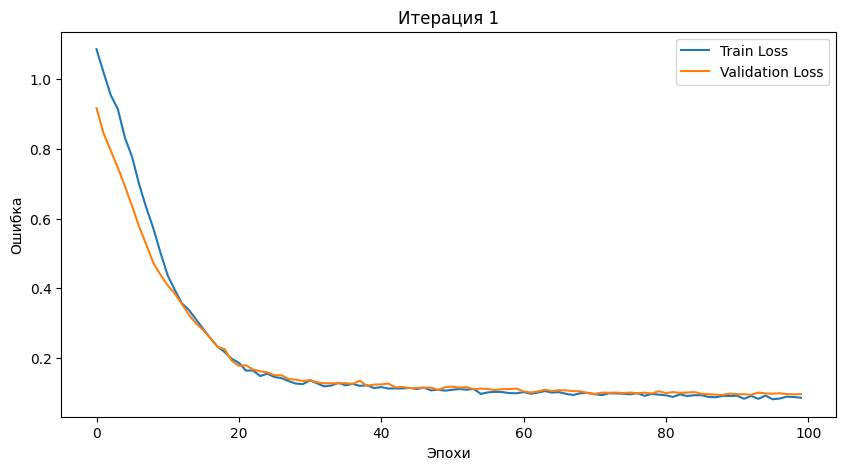

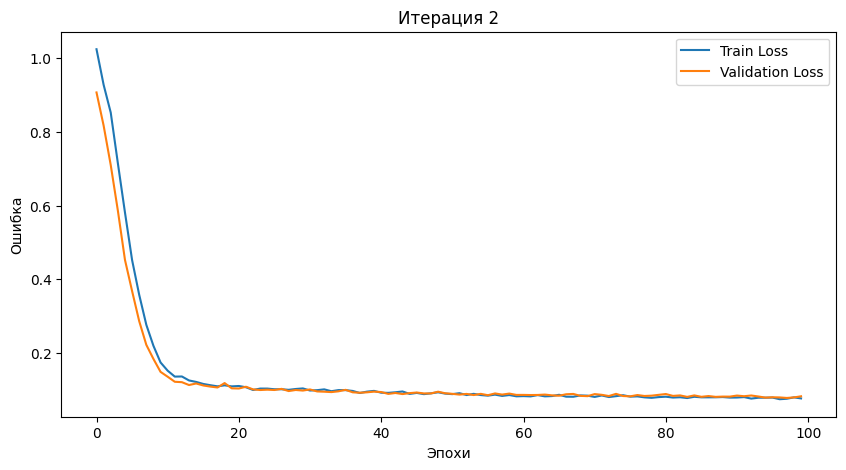

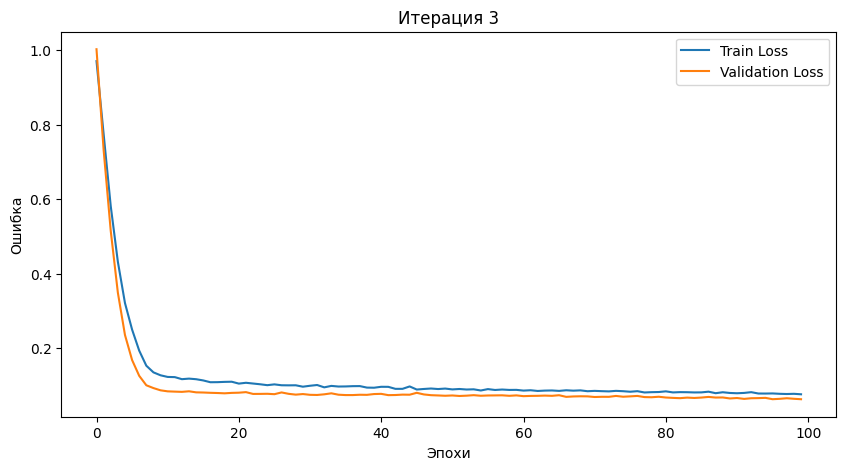

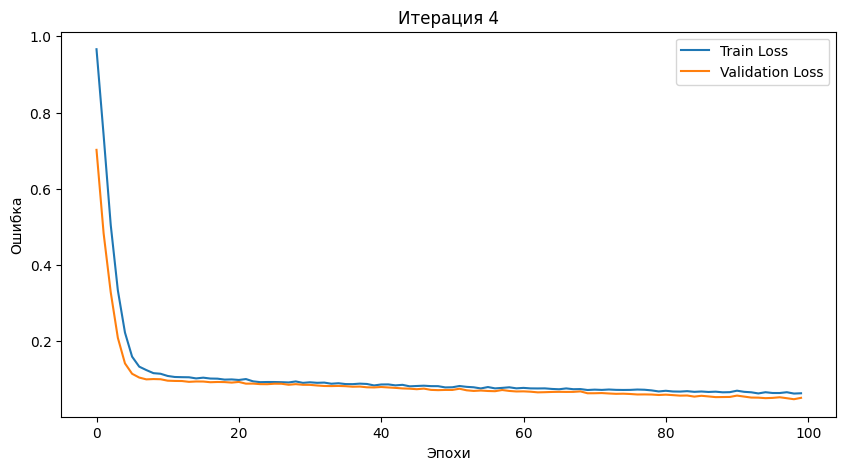

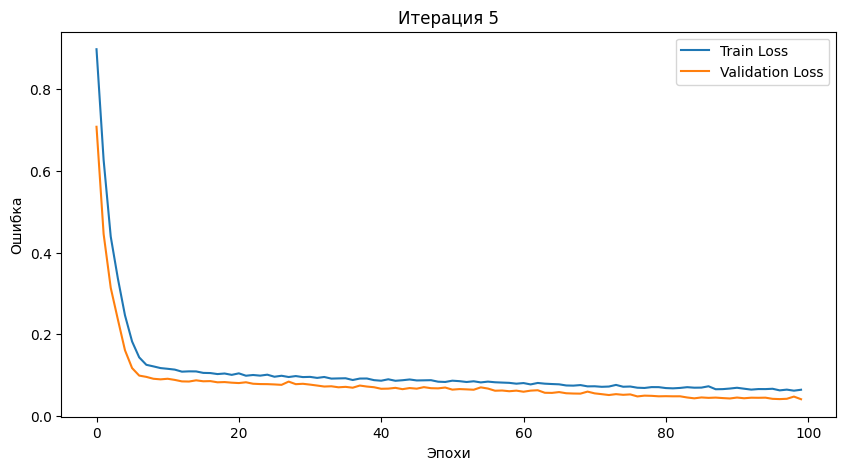

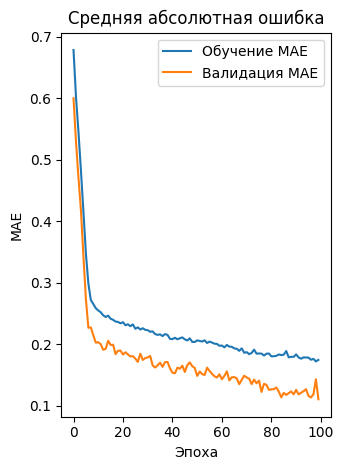

In [39]:
import matplotlib.pyplot as plt

# Визуализация обучения
for i, history in enumerate(history_list):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Итерация {i+1}')
    plt.xlabel('Эпохи')
    plt.ylabel('Ошибка')
    plt.legend()
    plt.show()

# График метрики MAE
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Обучение MAE')
plt.plot(history.history['val_mae'], label='Валидация MAE')
plt.title('Средняя абсолютная ошибка')
plt.xlabel('Эпоха')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [47]:
# Функция прогноза
def predict_next_year(model, scaler_X, scaler_y, df):
    next_year = df['Год'].max() + 1
    unique_directions = df['Направление'].unique()
    predictions = {}

    for direction in unique_directions:
        input_data = {
            'Год': next_year,
            'Пол': df['Пол'].mode()[0],
            'Возраст при зачислении': df['Возраст при зачислении'].mean(),
            'Дневная/вечерняя форма обучения': df['Дневная/вечерняя форма обучения'].mode()[0],
            'Вступительный балл': df['Вступительный балл'].mean(),
            'Направление': direction,
            'Предыдущее образование (оценка)': df['Предыдущее образование (оценка)'].mean()
        }
        input_df = pd.DataFrame(input_data, index=[0])
        input_scaled = scaler_X.transform(input_df)
        input_scaled = np.reshape(input_scaled, (input_scaled.shape[0], 1, input_scaled.shape[1]))

        prediction_scaled = model.predict(input_scaled)
        prediction = scaler_y.inverse_transform(prediction_scaled)[0][0]

        predictions[direction] = prediction

    return predictions

# Получение прогноза на следующий год
next_year_predictions = predict_next_year(final_model_lstm, scaler_X, scaler_y, df)

# Вывод результатов
for direction, count in next_year_predictions.items():
    print(f'Направление {direction}: {count:.2f} человек')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Направление 0.0: 219.97 человек
Направление 1.0: 233.06 человек
Направление 2.0: 246.15 человек
Направление 3.0: 326.04 человек
Направление 4.0: 553.93 человек
Направление 5.0: 746.57 человек
Направление 6.0: 768.37 человек
Направление 7.0: 356.67 человек
Направление 8.0: 290.28 человек
Направление 9.0: 254.46 человек
Направление 10.0: 260.49 человек
Н

In [46]:
# Группировка данных по годам и направлениям и подсчет количества строк
grouped_df = df.groupby(['Год', 'Направление']).size().reset_index(name='Количество абитуриентов')

# Проверка группированных данных
print("\nГруппированные данные:")
print(grouped_df)



Группированные данные:
     Год  Направление  Количество абитуриентов
0   2022          0.0                       81
1   2022          1.0                       71
2   2022          2.0                       84
3   2022          3.0                      118
4   2022          4.0                       67
5   2022          5.0                       85
6   2022          6.0                      258
7   2022          7.0                      102
8   2022          8.0                      112
9   2022          9.0                       59
10  2022         10.0                       95
11  2022         11.0                       47
12  2022         12.0                       28
13  2022         13.0                      135
14  2022         14.0                       61
15  2022         15.0                        8
16  2022         16.0                       64
17  2023          0.0                       61
18  2023          1.0                       90
19  2023          2.0               